## Lab 1 - algorytmy przeszukiwania tekstu

Biblioteki do zaimportowania:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import seaborn as sns

Załadowanie przykładowego pliku:

In [26]:
f = open('pan-tadeusz.txt', 'r')
text = f.read()

### Algorytm naiwny


In [4]:
#Matching function
def naive_string_matching(text, pattern):
    count = 0
    for s in range(0, len(text) - len(pattern) + 1):
        if (pattern == text[s:s + len(pattern)]):
            count+= 1
            # print(f"Przesunięcie {s} jest poprawne")
    return count

### Algorytm automatu skończonego

In [5]:
#Matching function
def fa_string_matching(text, delta):
    q = 0
    count = 0
    length = len(delta) - 1
    for i in range(0, len(text)):
        if text[i] in delta[q]:
            q = delta[q][text[i]]
            if (q == length):
                count += 1
                # print(f"Przesunięcie {i + 1 - q} jest poprawne")
                # ponieważ przeczytaliśmy (s+q)-ty znak te
        else:
            q = 0
    return count

#Function which generates table of transition values
def transition_table(pattern):
    alphabet = set(pattern)
    result = []
    for q in range(0, len(pattern) + 1):
        result.append({})
        for a in alphabet:
            k = min(len(pattern) + 1, q + 2)
            while True:
                k = k - 1
                # x[:k] - prefiks o długości k
                # x[-k:] - sufiks o długości k
                if (k == 0 or pattern[:k] == (pattern[:q] + a)[-k:]):
                    break
            result[q][a] = k
    return result

In [27]:
#An example of a function call

pattern = "pan"
delta = transition_table(pattern)
fa_string_matching(text,delta)

401

### Algorytm Knutha-Morrisa-Pratta

In [7]:
#Function which generates array of prefixes
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while(k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]
        if(pattern[k] == pattern[q]):
            k = k + 1
        pi.append(k)
    return pi

#Matching function
def kmp_string_matching(text, pattern,pi):
    q = 0
    count = 0
    for i in range(0, len(text)):
        while(q > 0 and pattern[q] != text[i]):
            q = pi[q-1]
        if(pattern[q] == text[i]):
            q = q + 1
        if(q == len(pattern)):
            count += 1
            # print(f"Przesunięcie {i + 1 - q} jest poprawne")
            q = pi[q-1]
    return count

Funkcje do porównywania czasu działania algorytmów


In [8]:
def function_time(text,pattern):
    data = []

    #Naive
    t = time()
    naive_string_matching(text,pattern)
    t_match = time()-t
    data.append([0,t_match,t_match,'naive'])

    #Finite-state
    t = time()
    delta = transition_table(pattern)
    t_prep = time()-t
    t = time()
    fa_string_matching(text,delta)
    t_match = time()-t
    data.append([t_prep,t_match,t_match+t_prep,'finite'])

    #Kmp
    t = time()
    pi = prefix_function(pattern)
    t_prep = time()-t
    t = time()
    kmp_string_matching(text,pattern,pi)
    t_match = time()-t
    data.append([t_prep,t_match,t_match+t_prep,'kmp'])

    df = pd.DataFrame(data=data,columns=['Preprocessing [s]','Matching [s]','Both [s]','Algorithm'])

    return df

In [30]:
function_time(text,"Tadeusz")

,Preprocessing [s],Matching [s],Both [s],Algorithm
0,0.000000,0.060344,0.060344,naive
1,0.000095,0.039824,0.039919,finite
2,0.000015,0.044156,0.044171,kmp


Algorytm automatu skończonego okazał się najszybszy.
Algorytm kmp jest ciut wolniejszy, sama konstrukcja tego algorytmu świadczy
o tym, że te algorytmy są porównywalne, aczkolwiek kmp wykonuje dużo więcej porównań.
Natomiast naiwny najwolniejszy - przez to, że sprawdzamy po kolei każde dopasowanie

In [10]:
def match_patterns(text,patterns):
    naive_data,fa_data,kmp_data = [],[],[]

    for pattern in patterns:
        naive = naive_string_matching(text,pattern)
        naive_data.append(naive)
        delta = transition_table(pattern)
        fa = fa_string_matching(text,delta)
        fa_data.append(fa)
        pi = prefix_function(pattern)
        kmp = kmp_string_matching(text,pattern,pi)
        kmp_data.append(kmp)
    naive_data.append('naive')
    fa_data.append('finite')
    kmp_data.append('kmp')
    data = [naive_data,fa_data,kmp_data]

    col = ['matching: ' + p + ' [s]' for p in patterns]
    col.append('algorithm')
    df = pd.DataFrame(data=data,columns=col)

    return df

In [11]:
match_patterns(text,['pan','pani'])

,matching: pan [s],matching: pani [s],algorithm
0,401,100,naive
1,401,100,finite
2,401,100,kmp


Oczywiście wyniki algorytmów uwzględniają duże i małe litery,
a więc przykładowo: 'Pani' != 'pani'

In [12]:
def function_time_n_times(text,pattern,n):
    naive_times,fa_times,kmp_times = [],[],[]
    for _ in range(n):
        t = time()
        naive_string_matching(text,pattern)
        naive_times.append(time()-t)
        t = time()
        delta = transition_table(pattern)
        fa_string_matching(text,delta)
        fa_times.append(time()-t)
        t = time()
        pi = prefix_function(pattern)
        kmp_string_matching(text,pattern,pi)
        kmp_times.append(time()-t)

    data = [[min(naive_times),max(naive_times),sum(naive_times)/n,pattern,'naive'],
            [min(fa_times),max(fa_times),sum(fa_times)/n,pattern,'finite'],
            [min(kmp_times),max(kmp_times),sum(kmp_times)/n,pattern,'kmp']
            ]

    data_plot = [[min(naive_times),'min',pattern,'naive'],
                 [max(naive_times),'max',pattern,'naive'],
                 [sum(naive_times)/n,'average',pattern,'naive'],
                 [min(fa_times),'min',pattern,'finite'],
                 [max(fa_times),'max',pattern,'finite'],
                 [sum(fa_times)/n,'average',pattern,'finite'],
                 [min(kmp_times),'min',pattern,'kmp'],
                 [max(kmp_times),'max',pattern,'kmp'],
                 [sum(kmp_times)/n,'average',pattern,'kmp']
                 ]
    df = pd.DataFrame(data=data,columns = ['min time [s]','max time [s]','average time [s]','pattern' ,'algorithm'])
    df_for_plot = pd.DataFrame(data=data_plot,columns = ['time','type','pattern' ,'algorithm'])
    return df,df_for_plot

In [20]:
df_a,df_for_plot_a = function_time_n_times(text,'pan',5)
df_a

,min time [s],max time [s],average time [s],pattern,algorithm
0,0.118375,0.155560,0.131856,pan,naive
1,0.059980,0.070481,0.062838,pan,finite
2,0.094141,0.127620,0.105670,pan,kmp


In [21]:
df_b,df_for_plot_b = function_time_n_times(text,'pani',5)
df_b

,min time [s],max time [s],average time [s],pattern,algorithm
0,0.116147,0.138877,0.130683,pani,naive
1,0.059431,0.101547,0.075225,pani,finite
2,0.092110,0.108506,0.099224,pani,kmp


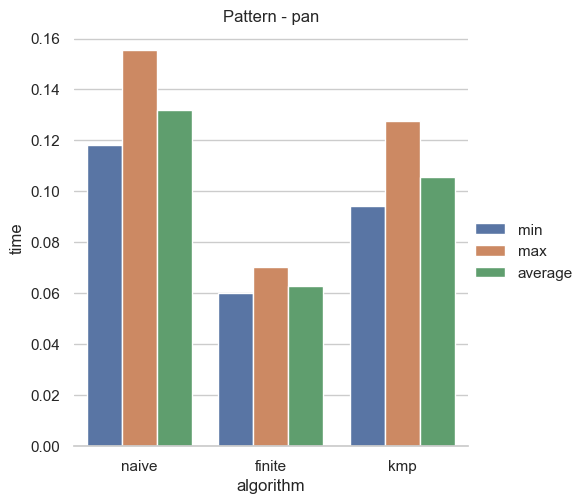

In [22]:
sns.set_theme(style="whitegrid")
g_1 = sns.catplot(data = df_for_plot_a,kind="bar",x = 'algorithm',y = 'time',hue='type')
g_1.set(title='Pattern - pan')
g_1.despine(left=True)
g_1.legend.set_title("")

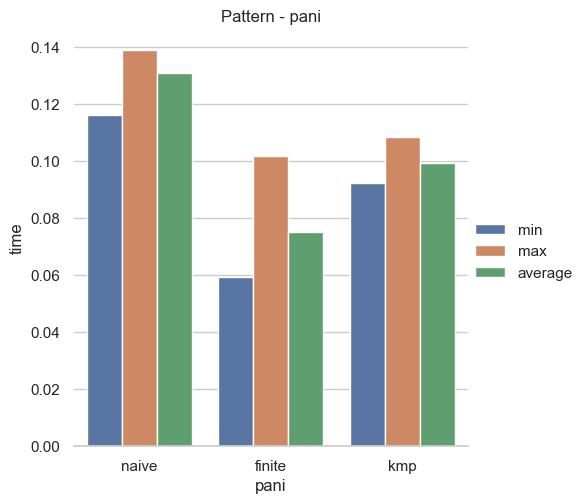

In [23]:
g_2 = sns.catplot(data = df_for_plot_b,kind="bar",x = 'algorithm',y = 'time',hue='type')
g_2.despine(left=True)
g_2.set(title='Pattern - pani')
g_2.set_axis_labels("pani")
g_2.legend.set_title("")

In [17]:
#Zamknięcie pan-tadeusz.txt
f.close()

Przykład patternu i textu, gdzie algorytm naive jest 5-krotnie wolniejszy:

-Dość długi text tego samego znaku, tak samo jak i pattern (pattern zbliżony do textu)

In [24]:
text = 'f' * 10**6
pattern = 'f' * 10**5

df = function_time(text,pattern)



In [25]:
df


,Preprocessing [s],Matching [s],Both [s],Algorithm
0,0.000000,10.013042,10.013042,naive
1,0.850040,0.109458,0.959498,finite
2,0.012636,0.177047,0.189683,kmp


### Wnioski
Po przeanalizowaniu wykresów i dataframeów, mogę stwierdzić, że naiwny algorytm jest najwolniejszy.
Generalnie im bardziej długość tekstu jest zbliżona do szukanego patternu (długościowo)
tym gorzej sobie radzi, (złożoność n^2 wtedy)
Natomiast pozostałe algorytmy radzą sobie w tym przypadku dużo lepiej (złożoność bliska liniowej)
Generalnie im bardziej pattern się powtarza tym szybsze te algorytmy będą
Dużo gorzej zaś będzie jeśli szukany pattern będzie mocno zróżnicowany, przykładowo jakiś
długi ciąg różnych znaków, czas poświęcony na pre-processing dla algorytmu automatów skończonych
będzie o wiele dłuższy, ze względu na to w jaki sposób się to generuje.
Wtedy dużo bezpieczniej wybrać algorytm kmp, który jest znacznie szybszy przy pre-processingu przez co
nadrabia, a nawet może okazać się dużo szybszy w takich przypadkach.

W tych testach, oczywiście wszędzie sobie radzi dużo lepiej automat skończonych, co
nie jest żadnym zaskoczeniem - bardzo krótki alfabet (p,a,n,i)
Automat zawsze będzie szybszy w przeszukiwaniu, natomiast wszystko zalezy też od pre-proecessingu i alfabetu
Co do kmp, jest delikatnie wolniejszy w przeszukiwaniu, aczkolwiek to dlatego,że automat działa na
słowniku, a kmp musi przez to dużo więcej warunków sprawdzać za każdym razem, u niego
góruje za to pre-processing, który jest dużo szybszy.

Naiwnego nie powinno się używac
generalnie im krótszy alfabet - algorytm automatów skończonych
przeciwnie - algorytm kmp